# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [30]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.367704
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [37]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.208439 analytic: -1.208439, relative error: 1.298383e-08
numerical: -0.034207 analytic: -0.034207, relative error: 1.795720e-06
numerical: -0.800635 analytic: -0.800635, relative error: 1.273949e-08
numerical: -1.968532 analytic: -1.968532, relative error: 8.913408e-09
numerical: -0.618644 analytic: -0.618644, relative error: 7.803890e-08
numerical: 0.451367 analytic: 0.451367, relative error: 5.694971e-08
numerical: 2.575662 analytic: 2.575661, relative error: 4.620142e-08
numerical: 2.338571 analytic: 2.338571, relative error: 1.789553e-08
numerical: -2.540606 analytic: -2.540606, relative error: 1.409694e-08
numerical: -1.995076 analytic: -1.995076, relative error: 7.394463e-09
numerical: -0.780105 analytic: -0.780105, relative error: 5.314081e-08
numerical: -1.282244 analytic: -1.282244, relative error: 2.272730e-08
numerical: -0.737350 analytic: -0.737350, relative error: 2.176383e-08
numerical: -0.768232 analytic: -0.768232, relative error: 8.573921e-09
numerical: -

In [42]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.367704e+00 computed in 0.062501s
(500, 10) delta
vectorized loss: 2.367704e+00 computed in 0.000000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# # Use the validation set to tune hyperparameters (regularization strength and
# # learning rate). You should experiment with different ranges for the learning
# # rates and regularization strengths; if you are careful you should be able to
# # get a classification accuracy of over 0.35 on the validation set.
# from cs231n.classifiers import Softmax
# results = {}
# best_val = -1
# best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [5e4, 1e8]

# ################################################################################
# # TODO:                                                                        #
# # Use the validation set to set the learning rate and regularization strength. #
# # This should be identical to the validation that you did for the SVM; save    #
# # the best trained softmax classifer in best_softmax.                          #
# ################################################################################
# pass
# ################################################################################
# #                              END OF YOUR CODE                                #
# ################################################################################
    
# # Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy)
    
# print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [51]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.35 on the validation set.
# learning_rates = [1e-7, 5e-5]
# regularization_strengths = [5e4, 1e5]

# learning_rates = [10 ** -x for x in np.arange(1,8,1)]
# regularization_strengths = [10 ** x for x in np.arange(1,4,1)]
from cs231n.classifiers import Softmax
learning_rates = [1e-9, 1e-7, 5e-5, 1e-4]
regularization_strengths = [1, 1e2 ,1e3, 5e3, 1e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#pass
num_iters =5000
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = Softmax()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters = num_iters, verbose=True)
        y_train_pred = svm.predict(X_train)
        print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        y_val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = (y_train_accuracy, y_val_accuracy)
        if (y_val_accuracy > best_val):
            best_val = y_val_accuracy
            best_svm = svm
        print("="*50)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 5.780843
iteration 100 / 5000: loss 5.658726
iteration 200 / 5000: loss 5.286932
iteration 300 / 5000: loss 5.772909
iteration 400 / 5000: loss 5.523474
iteration 500 / 5000: loss 5.606298
iteration 600 / 5000: loss 5.473097
iteration 700 / 5000: loss 5.802136
iteration 800 / 5000: loss 5.486262
iteration 900 / 5000: loss 6.087635
iteration 1000 / 5000: loss 5.310291
iteration 1100 / 5000: loss 5.550161
iteration 1200 / 5000: loss 4.955121
iteration 1300 / 5000: loss 4.888318
iteration 1400 / 5000: loss 5.460368
iteration 1500 / 5000: loss 5.197233
iteration 1600 / 5000: loss 4.980639
iteration 1700 / 5000: loss 4.946643
iteration 1800 / 5000: loss 5.259288
iteration 1900 / 5000: loss 5.523014
iteration 2000 / 5000: loss 5.238477
iteration 2100 / 5000: loss 5.170833
iteration 2200 / 5000: loss 4.865508
iteration 2300 / 5000: loss 5.261767
iteration 2400 / 5000: loss 4.568608
iteration 2500 / 5000: loss 4.565375
iteration 2600 / 5000: loss 5.145397
iteration 270

C:\Users\preri\Desktop\MLGeneral\CS230n\winter1516_assignment1\assignment1\cs231n\classifiers\softmax.py:132: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(softmax_corresponding_to_correct_labels))


iteration 200 / 5000: loss 61.638007
iteration 300 / 5000: loss 93.469035
iteration 400 / 5000: loss 103.000966
iteration 500 / 5000: loss 67.800033
iteration 600 / 5000: loss 78.317675
iteration 700 / 5000: loss 91.933839
iteration 800 / 5000: loss 85.887682
iteration 900 / 5000: loss 72.833665
iteration 1000 / 5000: loss 66.958695
iteration 1100 / 5000: loss 85.587513
iteration 1200 / 5000: loss 78.813268
iteration 1300 / 5000: loss 65.195506
iteration 1400 / 5000: loss 83.184303
iteration 1500 / 5000: loss 64.524265
iteration 1600 / 5000: loss 83.186477
iteration 1700 / 5000: loss 89.606381
iteration 1800 / 5000: loss 71.234141
iteration 1900 / 5000: loss 80.889507
iteration 2000 / 5000: loss 86.934947
iteration 2100 / 5000: loss 85.898993
iteration 2200 / 5000: loss 69.899930
iteration 2300 / 5000: loss 104.319510
iteration 2400 / 5000: loss 77.573838
iteration 2500 / 5000: loss 98.783204
iteration 2600 / 5000: loss 107.804797
iteration 2700 / 5000: loss 67.417466
iteration 2800 / 

In [58]:
# evaluate on test set
# Evaluate the best softmax on test set
best_softmax = best_svm
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.381000


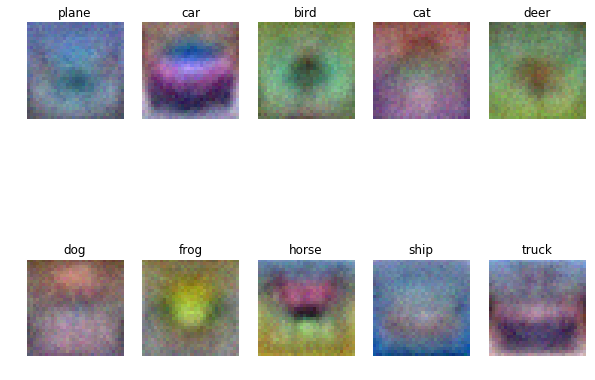

In [59]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])